In [1]:
import torch

print(torch.cuda.is_available())



True


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.mobile_optimizer import optimize_for_mobile
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image

# Crear el conjunto de datos
data_dir = "dataset"


training_dir = data_dir + "/training"
validation_dir = data_dir + "/validation"

## MobileNetV3 Large

In [3]:
from torchvision.models import MobileNet_V3_Large_Weights

model_name = "mobilenet_v3_large"
# Initialize the Weight Transforms
weights = MobileNet_V3_Large_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [5]:
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)


class_names = train_dataset.classes
print(class_names)

['anemona', 'barba_de_viejo', 'cachiyuyo', 'cadillo', 'calafate', 'canelo', 'chaura', 'flor_de_papel', 'frutilla_del_diablo', 'frutilla_silvestre', 'guindo', 'lenadura', 'lenga', 'maiten_enano', 'matanegra', 'michay', 'murtilla', 'nire', 'notro', 'orquidea_amarilla', 'palomita', 'parrilla', 'perezia_azul', 'punque', 'violeta_amarilla']


In [6]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[3] = nn.Linear(1280, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


epoch: 1 | train_acc: 0.5157 | val_acc: 0.7413 | loss 3.7416
epoch: 2 | train_acc: 0.7509 | val_acc: 0.7910 | loss 1.7031
epoch: 3 | train_acc: 0.8046 | val_acc: 0.7910 | loss 1.0822
epoch: 4 | train_acc: 0.8221 | val_acc: 0.8109 | loss 2.0748
epoch: 5 | train_acc: 0.8359 | val_acc: 0.8010 | loss 4.0866
epoch: 6 | train_acc: 0.8577 | val_acc: 0.7612 | loss 1.1995
epoch: 7 | train_acc: 0.8776 | val_acc: 0.8109 | loss 1.0540
epoch: 8 | train_acc: 0.8679 | val_acc: 0.7910 | loss 1.2731
epoch: 9 | train_acc: 0.8836 | val_acc: 0.8060 | loss 2.0046
epoch: 10 | train_acc: 0.8902 | val_acc: 0.8159 | loss 0.7924
epoch: 11 | train_acc: 0.8854 | val_acc: 0.8109 | loss 0.6635
epoch: 12 | train_acc: 0.8999 | val_acc: 0.7910 | loss 3.1315
epoch: 13 | train_acc: 0.8969 | val_acc: 0.8109 | loss 2.1730
epoch: 14 | train_acc: 0.9131 | val_acc: 0.8109 | loss 2.0068
epoch: 15 | train_acc: 0.9131 | val_acc: 0.8060 | loss 2.9202
epoch: 16 | train_acc: 0.9186 | val_acc: 0.8060 | loss 3.2362
epoch: 17 | train

In [8]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")

model successfully exported


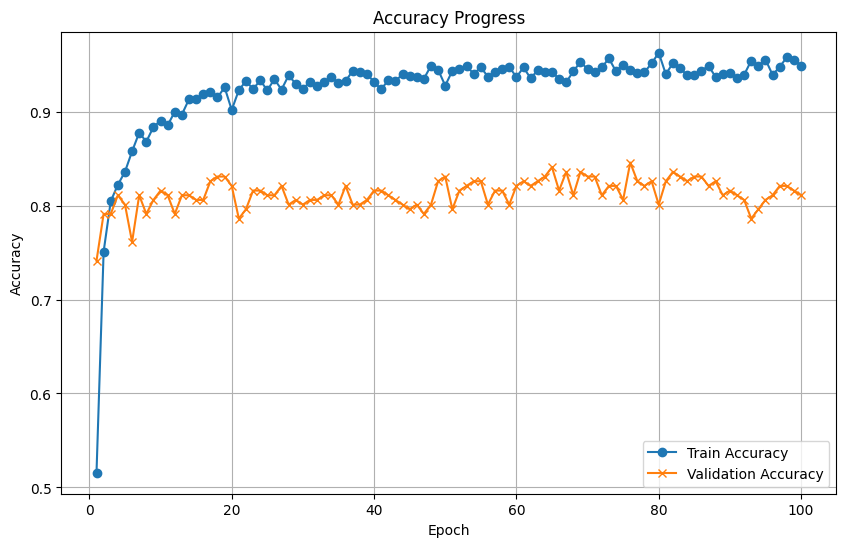

In [9]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


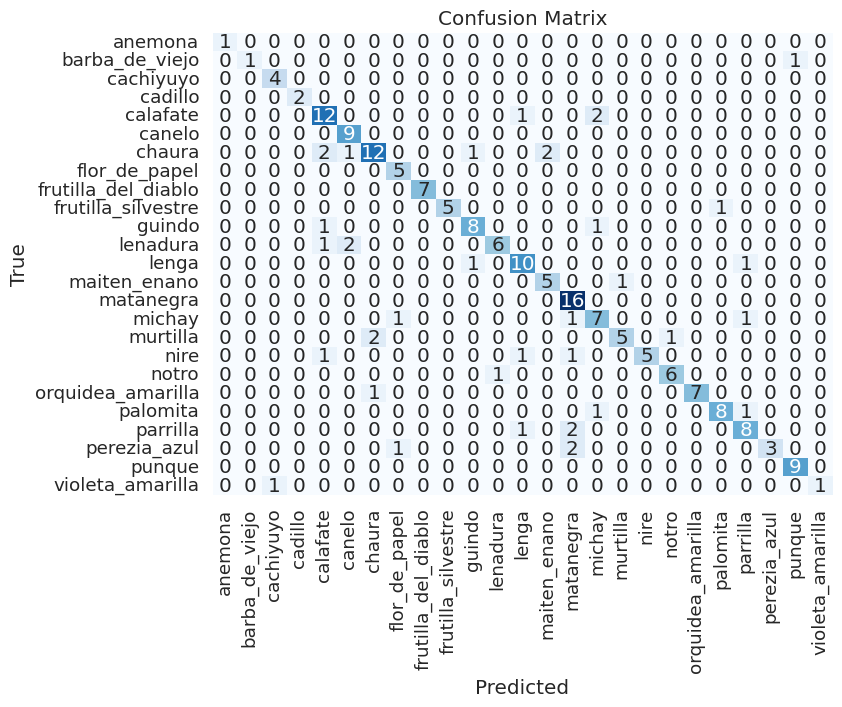

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.50      0.67         2
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         2
           4       0.71      0.80      0.75        15
           5       0.75      1.00      0.86         9
           6       0.80      0.67      0.73        18
           7       0.71      1.00      0.83         5
           8       1.00      1.00      1.00         7
           9       1.00      0.83      0.91         6
          10       0.80      0.80      0.80        10
          11       0.86      0.67      0.75         9
          12       0.77      0.83      0.80        12
          13       0.71      0.83      0.77         6
          14       0.73      1.00      0.84        16
          15       0.64      0.70      0.67        10
          16       0.83      0.62      0.71         8
          17       1.00    

In [10]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


## MobileNetV3 Small

In [11]:
from torchvision.models import MobileNet_V3_Small_Weights

model_name = "mobilenet_v3_small"
# Initialize the Weight Transforms
weights = MobileNet_V3_Small_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [12]:
# check normalize with last cell
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)

class_names = train_dataset.classes
print(class_names)

['anemona', 'barba_de_viejo', 'cachiyuyo', 'cadillo', 'calafate', 'canelo', 'chaura', 'flor_de_papel', 'frutilla_del_diablo', 'frutilla_silvestre', 'guindo', 'lenadura', 'lenga', 'maiten_enano', 'matanegra', 'michay', 'murtilla', 'nire', 'notro', 'orquidea_amarilla', 'palomita', 'parrilla', 'perezia_azul', 'punque', 'violeta_amarilla']


In [13]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[3] = nn.Linear(1024, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


epoch: 1 | train_acc: 0.4511 | val_acc: 0.7264 | loss 2.6254
epoch: 2 | train_acc: 0.6779 | val_acc: 0.7363 | loss 2.4894
epoch: 3 | train_acc: 0.7201 | val_acc: 0.7413 | loss 2.5127
epoch: 4 | train_acc: 0.7581 | val_acc: 0.7214 | loss 2.4091
epoch: 5 | train_acc: 0.7853 | val_acc: 0.7413 | loss 1.1144
epoch: 6 | train_acc: 0.7817 | val_acc: 0.7413 | loss 5.2498
epoch: 7 | train_acc: 0.8064 | val_acc: 0.7413 | loss 1.6744
epoch: 8 | train_acc: 0.8142 | val_acc: 0.7612 | loss 2.0371
epoch: 9 | train_acc: 0.8233 | val_acc: 0.7612 | loss 2.1487
epoch: 10 | train_acc: 0.8504 | val_acc: 0.7562 | loss 1.7186
epoch: 11 | train_acc: 0.8305 | val_acc: 0.7512 | loss 3.2366
epoch: 12 | train_acc: 0.8444 | val_acc: 0.7562 | loss 2.0588
epoch: 13 | train_acc: 0.8426 | val_acc: 0.7463 | loss 2.1972
epoch: 14 | train_acc: 0.8510 | val_acc: 0.7413 | loss 0.5709
epoch: 15 | train_acc: 0.8631 | val_acc: 0.7512 | loss 1.8959
epoch: 16 | train_acc: 0.8643 | val_acc: 0.7612 | loss 1.5980
epoch: 17 | train

In [15]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")

model successfully exported


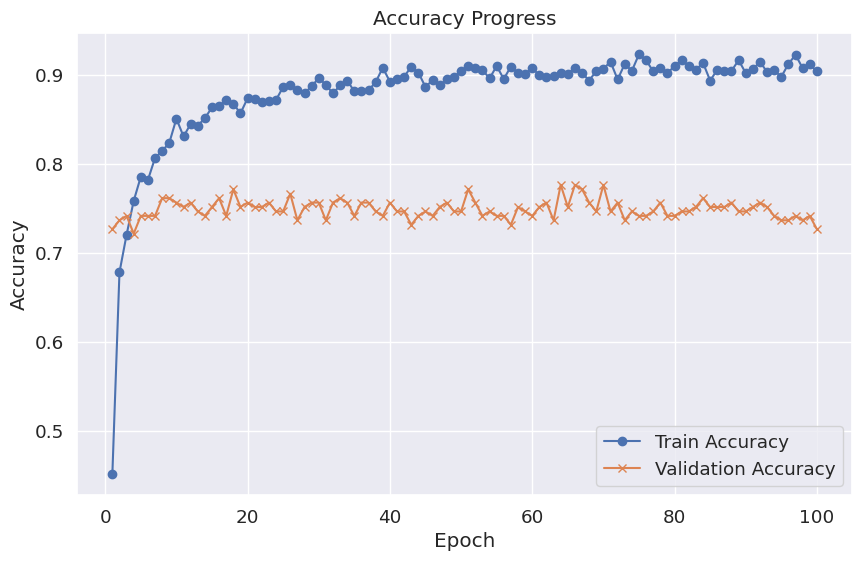

In [16]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


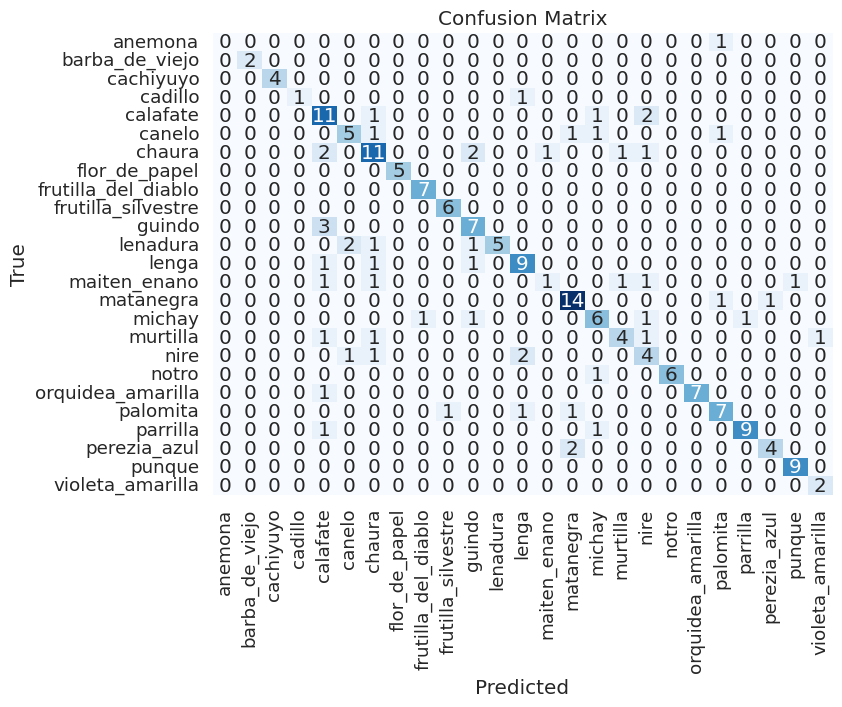

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      0.50      0.67         2
           4       0.52      0.73      0.61        15
           5       0.62      0.56      0.59         9
           6       0.61      0.61      0.61        18
           7       1.00      1.00      1.00         5
           8       0.88      1.00      0.93         7
           9       0.86      1.00      0.92         6
          10       0.58      0.70      0.64        10
          11       1.00      0.56      0.71         9
          12       0.69      0.75      0.72        12
          13       0.50      0.17      0.25         6
          14       0.78      0.88      0.82        16
          15       0.60      0.60      0.60        10
          16       0.67      0.50      0.57         8
          17       0.40    

/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [17]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


## EfficientNetV2 Large

In [49]:
from torchvision.models import EfficientNet_V2_L_Weights

model_name = "efficientnet_v2_l"
# Initialize the Weight Transforms
weights = EfficientNet_V2_L_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)


In [55]:
# check normalize with last cell
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)

class_names = train_dataset.classes
print(class_names)

['anemona', 'barba_de_viejo', 'cachiyuyo', 'cadillo', 'calafate', 'canelo', 'chaura', 'flor_de_papel', 'frutilla_del_diablo', 'frutilla_silvestre', 'guindo', 'lenadura', 'lenga', 'maiten_enano', 'matanegra', 'michay', 'murtilla', 'nire', 'notro', 'orquidea_amarilla', 'palomita', 'parrilla', 'perezia_azul', 'punque', 'violeta_amarilla']


In [56]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [57]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[1] = nn.Linear(1280, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


epoch: 1 | train_acc: 0.4445 | val_acc: 0.7861 | loss 1.8154


In [ ]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")


model successfully exported


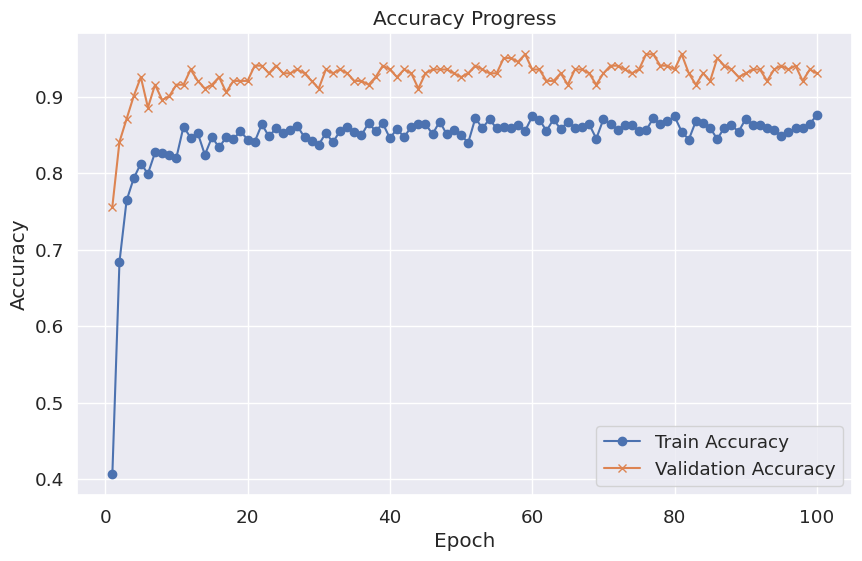

In [ ]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


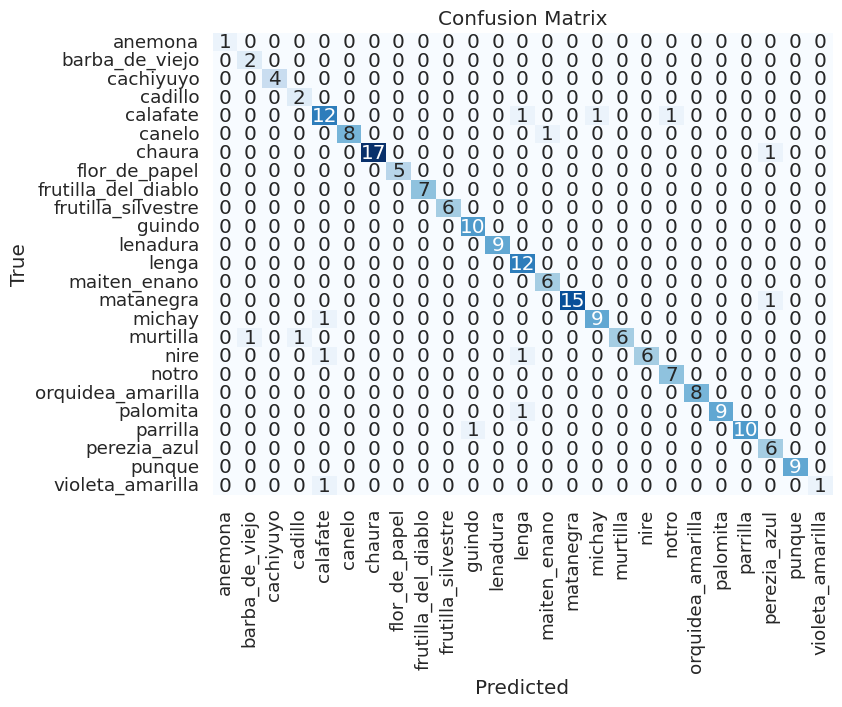

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         4
           3       0.67      1.00      0.80         2
           4       0.80      0.80      0.80        15
           5       1.00      0.89      0.94         9
           6       1.00      0.94      0.97        18
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         6
          10       0.91      1.00      0.95        10
          11       1.00      1.00      1.00         9
          12       0.80      1.00      0.89        12
          13       0.86      1.00      0.92         6
          14       1.00      0.94      0.97        16
          15       0.90      0.90      0.90        10
          16       1.00      0.75      0.86         8
          17       1.00    

In [ ]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


## EfficientNetV2 Medium

In [ ]:
from torchvision.models import EfficientNet_V2_M_Weights

model_name = "efficientnet_v2_m"
# Initialize the Weight Transforms
weights = EfficientNet_V2_M_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# check normalize with last cell
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.Resize(480),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize(480),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)


class_names = train_dataset.classes
print(class_names)


['anemona', 'barba_de_viejo', 'cachiyuyo', 'cadillo', 'calafate', 'canelo', 'chaura', 'flor_de_papel', 'frutilla_del_diablo', 'frutilla_silvestre', 'guindo', 'lenadura', 'lenga', 'maiten_enano', 'matanegra', 'michay', 'murtilla', 'nire', 'notro', 'orquidea_amarilla', 'palomita', 'parrilla', 'perezia_azul', 'punque', 'violeta_amarilla']


In [ ]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[1] = nn.Linear(1280, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


epoch: 1 | train_acc: 0.3824 | val_acc: 0.6617 | loss 2.7026
epoch: 2 | train_acc: 0.6080 | val_acc: 0.7562 | loss 1.1787
epoch: 3 | train_acc: 0.7087 | val_acc: 0.7761 | loss 2.5141
epoch: 4 | train_acc: 0.7443 | val_acc: 0.8109 | loss 0.8964
epoch: 5 | train_acc: 0.7485 | val_acc: 0.8109 | loss 0.6768
epoch: 6 | train_acc: 0.7563 | val_acc: 0.8060 | loss 2.3451
epoch: 7 | train_acc: 0.7714 | val_acc: 0.7960 | loss 1.4247
epoch: 8 | train_acc: 0.7768 | val_acc: 0.8458 | loss 0.5151
epoch: 9 | train_acc: 0.7805 | val_acc: 0.8408 | loss 1.3785
epoch: 10 | train_acc: 0.7829 | val_acc: 0.8259 | loss 1.0481
epoch: 11 | train_acc: 0.7992 | val_acc: 0.8358 | loss 3.8479
epoch: 12 | train_acc: 0.8070 | val_acc: 0.8308 | loss 1.2722
epoch: 13 | train_acc: 0.8070 | val_acc: 0.8209 | loss 1.0036
epoch: 14 | train_acc: 0.7992 | val_acc: 0.8259 | loss 0.4905
epoch: 15 | train_acc: 0.8251 | val_acc: 0.8209 | loss 1.3476
epoch: 16 | train_acc: 0.8010 | val_acc: 0.8408 | loss 1.6853
epoch: 17 | train

In [ ]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")


model successfully exported


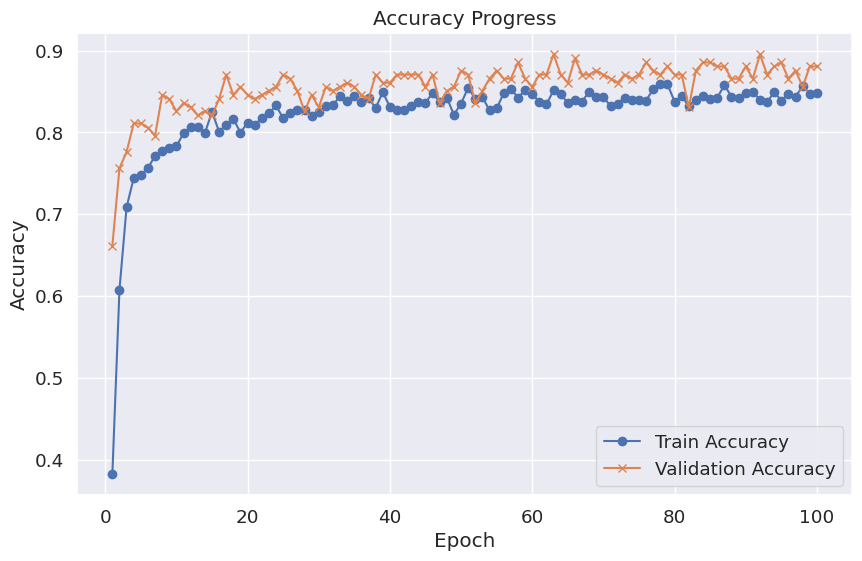

In [ ]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


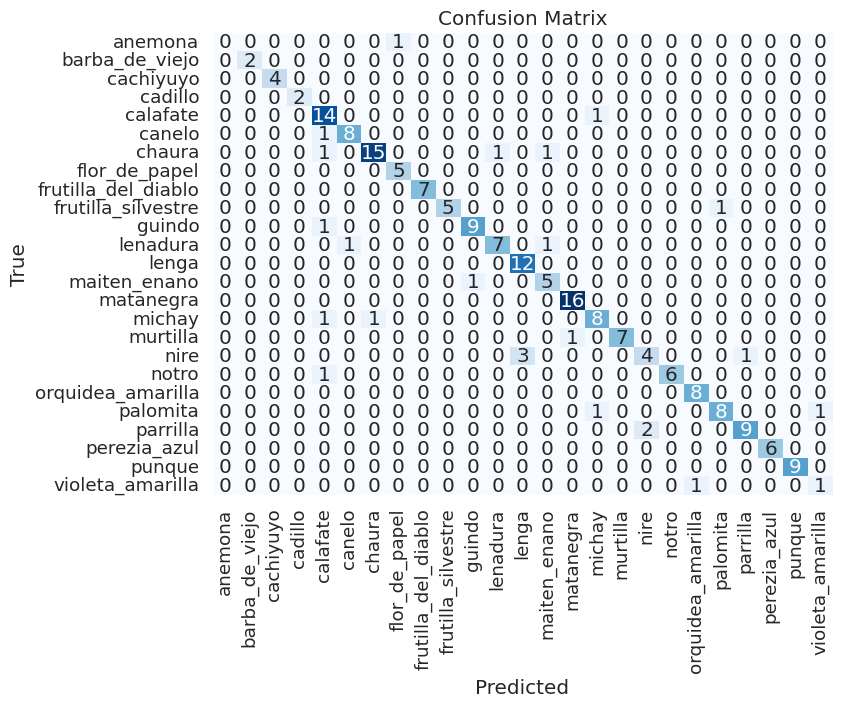

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       0.74      0.93      0.82        15
           5       0.89      0.89      0.89         9
           6       0.94      0.83      0.88        18
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         7
           9       1.00      0.83      0.91         6
          10       0.90      0.90      0.90        10
          11       0.88      0.78      0.82         9
          12       0.80      1.00      0.89        12
          13       0.71      0.83      0.77         6
          14       0.94      1.00      0.97        16
          15       0.80      0.80      0.80        10
          16       1.00      0.88      0.93         8
          17       0.67    

/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


## EfficientNetV2 Small

In [ ]:
from torchvision.models import EfficientNet_V2_S_Weights

model_name = "efficientnet_v2_s"
# Initialize the Weight Transforms
weights = EfficientNet_V2_S_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# check normalize with last cell
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.Resize(384),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize(384),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)


In [ ]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[1] = nn.Linear(1280, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


epoch: 1 | train_acc: 0.3758 | val_acc: 0.6219 | loss 3.3498
epoch: 2 | train_acc: 0.6236 | val_acc: 0.6965 | loss 3.1620
epoch: 3 | train_acc: 0.6912 | val_acc: 0.7114 | loss 2.2815
epoch: 4 | train_acc: 0.7298 | val_acc: 0.7413 | loss 2.3038
epoch: 5 | train_acc: 0.7358 | val_acc: 0.7363 | loss 1.7600
epoch: 6 | train_acc: 0.7618 | val_acc: 0.7562 | loss 2.0537
epoch: 7 | train_acc: 0.7793 | val_acc: 0.7512 | loss 2.9202
epoch: 8 | train_acc: 0.7780 | val_acc: 0.7512 | loss 1.9971
epoch: 9 | train_acc: 0.7780 | val_acc: 0.7711 | loss 3.1341
epoch: 10 | train_acc: 0.7913 | val_acc: 0.7413 | loss 2.2190
epoch: 11 | train_acc: 0.7835 | val_acc: 0.7711 | loss 1.8319
epoch: 12 | train_acc: 0.7979 | val_acc: 0.8109 | loss 2.6699
epoch: 13 | train_acc: 0.8058 | val_acc: 0.8060 | loss 0.9133
epoch: 14 | train_acc: 0.7883 | val_acc: 0.7861 | loss 1.6484
epoch: 15 | train_acc: 0.8160 | val_acc: 0.7811 | loss 0.3257
epoch: 16 | train_acc: 0.8076 | val_acc: 0.8010 | loss 2.4616
epoch: 17 | train

In [ ]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")


model successfully exported


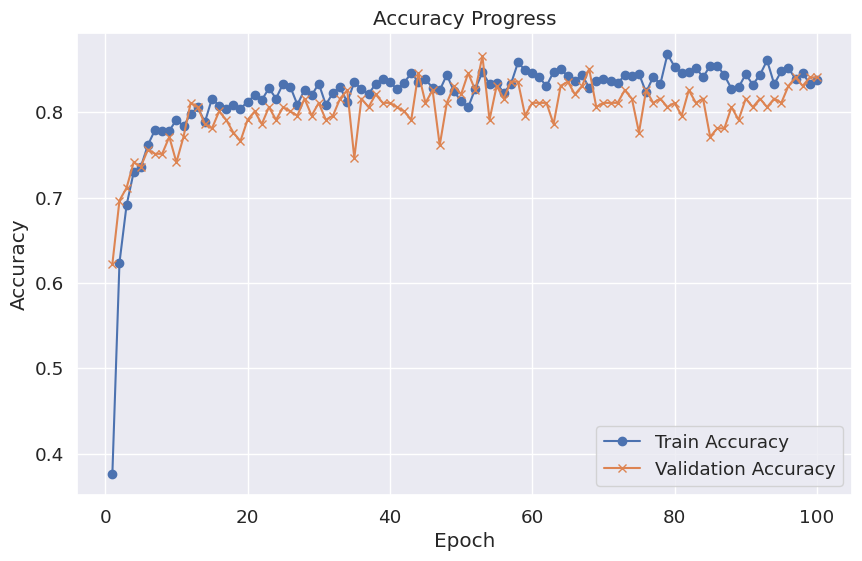

In [ ]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


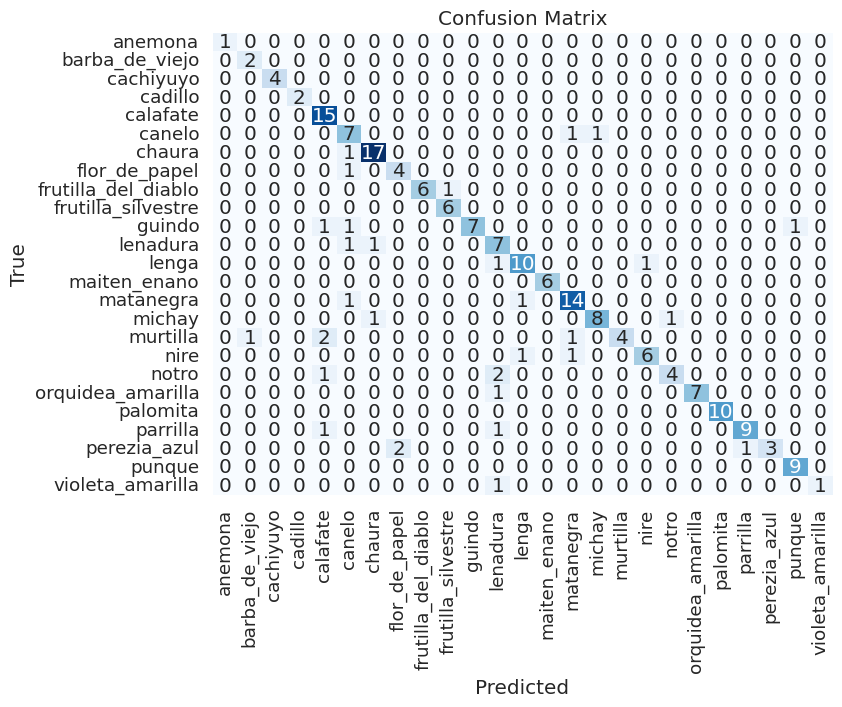

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       0.75      1.00      0.86        15
           5       0.58      0.78      0.67         9
           6       0.89      0.94      0.92        18
           7       0.67      0.80      0.73         5
           8       1.00      0.86      0.92         7
           9       0.86      1.00      0.92         6
          10       1.00      0.70      0.82        10
          11       0.54      0.78      0.64         9
          12       0.83      0.83      0.83        12
          13       1.00      1.00      1.00         6
          14       0.82      0.88      0.85        16
          15       0.89      0.80      0.84        10
          16       1.00      0.50      0.67         8
          17       0.86    

In [ ]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


In [ ]:
from torchvision.models import ViT_B_16_Weights

model_name = "vit_b_16"
# Initialize the Weight Transforms
weights = ViT_B_16_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# check normalize with last cell
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)


In [ ]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, weights=ViT_B_16_Weights.DEFAULT)
print(backbone)

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/brigoni/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100.0%


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.heads.head = nn.Linear(in_features=768, out_features=len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


epoch: 1 | train_acc: 0.5995 | val_acc: 0.7114 | loss 0.2585
epoch: 2 | train_acc: 0.7961 | val_acc: 0.7811 | loss 0.1584
epoch: 3 | train_acc: 0.8522 | val_acc: 0.7662 | loss 0.2581
epoch: 4 | train_acc: 0.8824 | val_acc: 0.7811 | loss 1.9811
epoch: 5 | train_acc: 0.8975 | val_acc: 0.7960 | loss 0.5703
epoch: 6 | train_acc: 0.9029 | val_acc: 0.7910 | loss 0.0643
epoch: 7 | train_acc: 0.9047 | val_acc: 0.8358 | loss 0.4380
epoch: 8 | train_acc: 0.9053 | val_acc: 0.8557 | loss 0.0566
epoch: 9 | train_acc: 0.9144 | val_acc: 0.8308 | loss 0.0155
epoch: 10 | train_acc: 0.9282 | val_acc: 0.8308 | loss 0.0100
epoch: 11 | train_acc: 0.9252 | val_acc: 0.8358 | loss 1.1100
epoch: 12 | train_acc: 0.9385 | val_acc: 0.8458 | loss 0.0943
epoch: 13 | train_acc: 0.9324 | val_acc: 0.8507 | loss 0.1465
epoch: 14 | train_acc: 0.9427 | val_acc: 0.8159 | loss 0.4125
epoch: 15 | train_acc: 0.9367 | val_acc: 0.8358 | loss 0.0881
epoch: 16 | train_acc: 0.9318 | val_acc: 0.8408 | loss 0.6571
epoch: 17 | train

In [ ]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")


model successfully exported


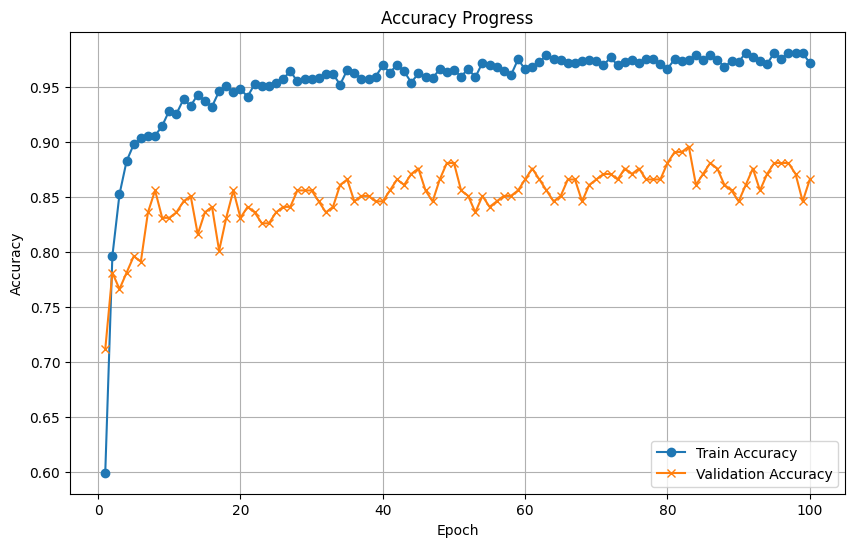

In [ ]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


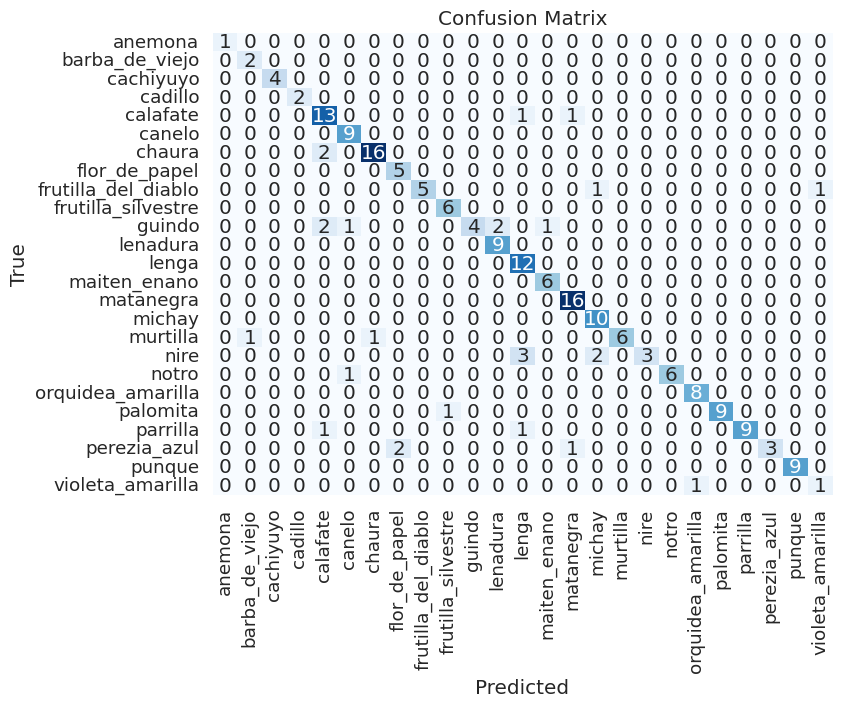

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       0.72      0.87      0.79        15
           5       0.82      1.00      0.90         9
           6       0.94      0.89      0.91        18
           7       0.71      1.00      0.83         5
           8       1.00      0.71      0.83         7
           9       0.86      1.00      0.92         6
          10       1.00      0.40      0.57        10
          11       0.82      1.00      0.90         9
          12       0.71      1.00      0.83        12
          13       0.86      1.00      0.92         6
          14       0.89      1.00      0.94        16
          15       0.77      1.00      0.87        10
          16       1.00      0.75      0.86         8
          17       1.00    

In [ ]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))
